In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from statsmodels.graphics.tsaplots import plot_acf
import datetime
from datetime import timedelta
import ipywidgets as widgets
from IPython.display import display

In [2]:
df_combined = pd.read_csv('data/2022-2024_Stats.csv')
df_productivity = pd.read_csv('data/Case_Closure_(Oct22-Jan24)_cleaned.csv')

# Let users choose between Weekly or Monthly

In [3]:
# Define button options and their corresponding parameters
button_options = {
    "Weekly": {"train_days": df_combined[-60:], "num_steps": 7, "p": 7, "d": 1, "q": 2,
               "start_date": pd.Timestamp('2024-03-25'), "td_days": 6, "manpower_days": df_productivity[-60:]},
    "Monthly": {"train_days": df_combined[-100:], "num_steps": 30, "p": 7, "d": 1, "q": 1,
               "start_date": pd.Timestamp('2024-03-25'), "td_days": 29, "manpower_days": df_productivity[-100:]}
}

# Define a function to handle button clicks
def on_button_clicked(b):
    global clicked_button, train_days, num_steps, p, d, q, start_date, end_date, manpower_days
    clicked_button = b.description
    print("Button clicked:", clicked_button)

    # Update parameters based on the clicked button
    parameters = button_options.get(clicked_button)
    if parameters:
        train_days = parameters["train_days"]
        num_steps = parameters["num_steps"]
        p, d, q = parameters["p"], parameters["d"], parameters["q"]
        start_date = parameters["start_date"].date()
        td_days = parameters["td_days"]
        end_date = start_date + timedelta(days=td_days)
        manpower_days = parameters["manpower_days"]
        print(len(train_days), num_steps, p, d, q, start_date, end_date, td_days, len(manpower_days))

# Create buttons
buttons = [widgets.Button(description=option) for option in button_options]

# Assign callbacks to buttons
for button in buttons:
    button.on_click(on_button_clicked)

# Display buttons
display(*buttons)

Button(description='Weekly', style=ButtonStyle())

Button(description='Monthly', style=ButtonStyle())

Button clicked: Weekly
60 7 7 1 2 2024-03-25 2024-03-31 6 60


# New Cases: Dynamic Updating of ARIMA

Currently only works if you update for one day

In [ ]:
# only putting this here in case i need to clear input
df_combined = pd.read_csv('data/2022-2024_Stats.csv')
df_combined

In [58]:
# input updated numbers for today

open_balance_input = input("Enter today's Open Balance: ")
close_balance_input = input("Enter today's Close Balance: ")
new_balance_input = input("Enter today's New Balance: ")
surge_input = input("Enter Expected Surge Input: ")


original_data = []

# this code causes us to only be able to input 1 day of real values.
# need to find a way to make this more dynamic but for now its workable
train_days = df_combined[-60:]

if open_balance_input.strip() and close_balance_input.strip() and new_balance_input.strip():
    try:
        open_balance = float(open_balance_input)
        close_balance = float(close_balance_input)
        new_balance = float(new_balance_input)
    except ValueError:
        print("Error: Please enter valid numbers for balances.")
    else:
        original_data.append(df_combined.iloc[-1])
        train_days = train_days.drop(df_combined.index[-1])
        new_data = {'Date': start_date,
                    'Open Balances': open_balance,
                    'Closed': close_balance,
                    'New Cases': new_balance
                    }
        train_days = train_days.append(new_data, ignore_index=True)
        print("Values successfully added to DataFrame.")
        print(train_days[-7:])
        
surge_amt=[]

if surge_input.strip(): 
    try:
        surge_amt = float(surge_input)
    except ValueError:
            print("Error: Please enter valid numbers for percentage increase.")

Enter today's Open Balance: 3241
Enter today's Close Balance: 341
Enter today's New Balance: 231
Enter Expected Surge Input: 2
Values successfully added to DataFrame.
          Date  Open Balances  Closed  New Cases
53  2024-03-19         2786.0   465.0      490.0
54  2024-03-20         2737.0   410.0      390.0
55  2024-03-21         2521.0   429.0      428.0
56  2024-03-22         2499.0   432.0      406.0
57  2024-03-23         2473.0    11.0      211.0
58  2024-03-24         2673.0     0.0      214.0
59  2024-03-25         3241.0   341.0      231.0


/var/folders/9d/9y37blc53yz64mgqtz66xrrw0000gp/T/ipykernel_11219/3516134786.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_days = train_days.append(new_data, ignore_index=True)


In [59]:
def arima_dynamic_forecast(train_days, num_steps, p, d, q, surge_amt, var_to_pred):

    
    # Extract the 'Open Balances' column
    combined_train_data = train_days[var_to_pred]

    # Initialize history with combined training data
    history = [x for x in combined_train_data]

    predictions = list()

    # Iterate over the number of time steps to make predictions for 2024
    for i in range(num_steps):
        # Fit ARIMA model with seasonal differencing
        model = ARIMA(history, order=(p, d, q))
        model_fit = model.fit()

        # Forecast the next value
        yhat = model_fit.forecast()[0]
        # Append the forecasted value to predictions
        predictions.append(yhat)

        # Update the history with the forecasted value
        history.append(yhat)

    # Now predictions_2024 contains the predicted values for 2024

    print(surge_amt)
    # if no surge input
    if not surge_amt:
        print('no % increase')
        print(predictions)
        return predictions
    else:
        percentage_increase = 1 + surge_amt / 100
        for i in range(len(predictions)):
            predictions[i] *= percentage_increase
        print('have % increase', percentage_increase, predictions)
        return predictions


In [60]:
new_cases_pred = arima_dynamic_forecast(train_days, num_steps, p, d, q, surge_amt, var_to_pred='New Cases')

/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/user/opt/anaconda3/lib/python3.9/site-packages/st

2.0
have % increase 1.02 [323.59002950012126, 292.54048525426737, 328.91500682748745, 335.4447297092733, 212.36898999992886, 193.91735437082096, 241.10988356650307]


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [61]:
def analyse_dynamic_pred(df_combined, predictions, start_date, end_date, var_to_pred):
    # Create time index
    time_index_2024 = pd.date_range(start=start_date, end=end_date, freq='D')

    # Plotting
    plt.figure(figsize=(10, 6))
    
    original_values = [row[var_to_pred] for row in original_data]
    
    stop_pt = len(original_values)

    # if full arima prediction
    if stop_pt == 0:
        plt.plot(time_index_2024, predictions, label='Predictions 2024', color='red')
    
    else:
        plt.bar(time_index_2024[:stop_pt], original_values, label='Correct 2024', color='blue')
        # Plot predicted values
        plt.plot(time_index_2024[stop_pt:], predictions[stop_pt:], label='Predictions 2024', color='red')
        plt.title('ARIMA Forecast on ' + var_to_pred)
        plt.xlabel('Date')
        plt.ylabel(var_to_pred)
        plt.legend()
        plt.grid(True)
        plt.show()

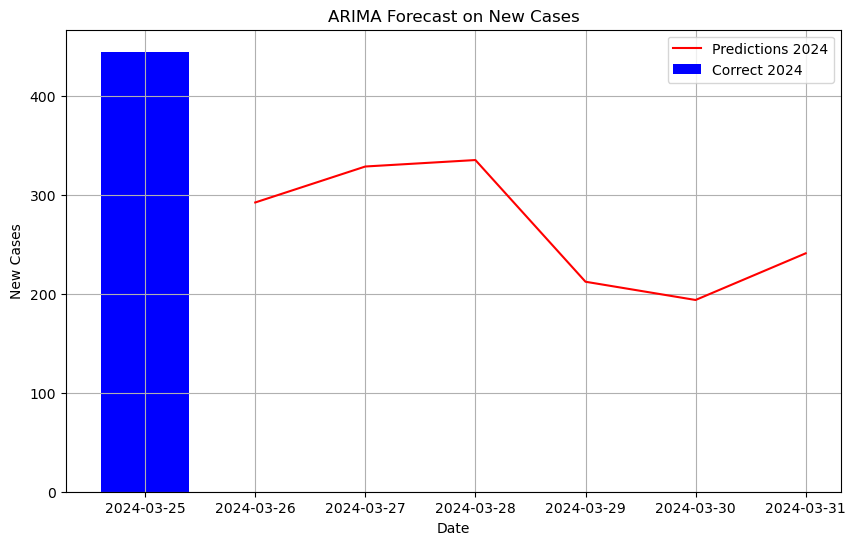

In [62]:
analyse_dynamic_pred(df_combined, new_cases_pred, start_date, end_date, var_to_pred='New Cases')

# Closed Cases: Dynamic Updating of Simulation

PSA: This one cannot update after the initial prediction because we don't have input for average case closure rate.

In [65]:
def prod_forecast(manpower_days, num_steps, p, d, q, surge_amt):
    
    # predict csa
    csa_train_data = manpower_days['Avg Case Closed Per CSA']

    # Initialize history with combined training data
    csa_history = [x for x in csa_train_data]

    csa = list()

    # Iterate over the number of time steps to make predictions for 2024
    for i in range(num_steps):
        # Fit ARIMA model with seasonal differencing
        model = ARIMA(csa_history, order=(p, d, q))
        model_fit = model.fit()

        # Forecast the next value
        yhat = model_fit.forecast()[0]
        # Append the forecasted value to predictions
        csa.append(yhat)

        # Update the history with the forecasted value
        csa_history.append(yhat)
        
    # predict cse
    cse_train_data = manpower_days['Avg Case Closed Per CSE']

    # Initialize history with combined training data
    cse_history = [x for x in cse_train_data]

    cse = list()

    # Iterate over the number of time steps to make predictions for 2024
    for i in range(num_steps):
        # Fit ARIMA model with seasonal differencing
        model = ARIMA(cse_history, order=(p, d, q))
        model_fit = model.fit()

        # Forecast the next value
        yhat = model_fit.forecast()[0]
        # Append the forecasted value to predictions
        cse.append(yhat)

        # Update the history with the forecasted value
        cse_history.append(yhat)
        
    # predict temps
    temps_train_data = manpower_days['Avg Case Closed per Temp']

    # Initialize history with combined training data
    temp_history = [x for x in temps_train_data]

    temp = list()

    # Iterate over the number of time steps to make predictions for 2024
    for i in range(num_steps):
        # Fit ARIMA model with seasonal differencing
        model = ARIMA(temp_history, order=(p, d, q))
        model_fit = model.fit()

        # Forecast the next value
        yhat = model_fit.forecast()[0]
        # Append the forecasted value to predictions
        temp.append(yhat)

        # Update the history with the forecasted value
        temp_history.append(yhat)
    
    if not surge_amt:
        print('no % increase')
        print(csa, cse, temp)
        return csa, cse, temp
    else:
        percentage_increase = 1 + surge_amt / 100
        for i in range(len(csa)):
            csa[i] *= percentage_increase
            cse[i] *= percentage_increase
            temp[i] *= percentage_increase
        print('have % increase', percentage_increase, csa, cse, temp)
        return csa, cse, temp


In [66]:
csa, cse, temp = prod_forecast(manpower_days, num_steps, p, d, q, surge_amt)

print('csa \n', csa, 'cse \n', cse, 'temp \n', temp)

/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/user/opt/anaconda3/lib/python3.9/site-packages/st

7 7 7
have % increase 1.02 [23.655454895383574, 18.754670422971845, 1.126634489307967, 1.5283889559957171, 21.6717936357059, 20.91143559290788, 21.823157594035607] [29.517186046172164, 25.534329579730016, 2.1725974885687607, 7.503567637278716, 28.599245728853887, 27.128184764788998, 23.714414032077997] [15.129421878554673, 9.422384450321706, -1.0321429704421645, 2.885173310199761, 11.561469039381482, 7.37600795302764, 7.978776354844642]
csa 
 [23.655454895383574, 18.754670422971845, 1.126634489307967, 1.5283889559957171, 21.6717936357059, 20.91143559290788, 21.823157594035607] cse 
 [29.517186046172164, 25.534329579730016, 2.1725974885687607, 7.503567637278716, 28.599245728853887, 27.128184764788998, 23.714414032077997] temp 
 [15.129421878554673, 9.422384450321706, -1.0321429704421645, 2.885173310199761, 11.561469039381482, 7.37600795302764, 7.978776354844642]


In [18]:
# input updated numbers for today

csa_input = input("Enter CSA Manpower: ")
cse_input = input("Enter CSE Manpower: ")
temps_input = input("Enter Temp Manpower: ")

try:
    csa_input = float(csa_input)
    cse_input = float(cse_input)
    temps_input = float(temps_input)
except ValueError:
    print("Error: Please enter valid numbers.")
else:
    # Initialize the result array
    cases_closed = []

    # Perform element-wise multiplication and summation
    for csa_val, cse_val, temp_val in zip(csa, cse, temp):
        cases_closed.append(csa_input * csa_val + cse_input * cse_val + temps_input * temp_val)

    print(cases_closed)

Enter CSA Manpower: 20
Enter CSE Manpower: 10
Enter Temp Manpower: 5
[827.3804585903592, 664.2633593219074, 38.331323352584434, 117.67580592519639, 761.9957599995729, 712.1476463442998, 699.5109548781522]


In [19]:
def analyse_pred(cases_closed, start_date, end_date, var_to_sim):
    # Create time index
    time_index_2024 = pd.date_range(start=start_date, end=end_date, freq='D')

    # Plotting
    plt.figure(figsize=(10, 6))

    #plt.plot(time_index_2024, open_balances_values, label='Correct 2024', color='blue')

    # Plot predicted values for 2024
    plt.plot(time_index_2024, cases_closed, label='Simulated '+var_to_sim, color='red')
    plt.title(var_to_sim+' Simulation')
    plt.xlabel('Date')
    plt.ylabel(var_to_sim)
    plt.legend()
    plt.grid(True)
    plt.show()

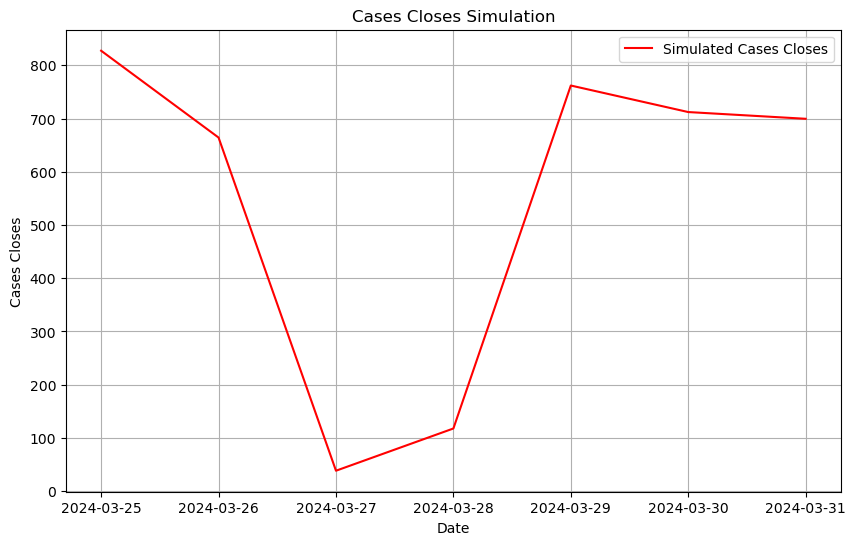

In [20]:
analyse_pred(cases_closed, start_date, end_date, var_to_sim='Cases Closes')

# Open Balance: Dynamic Updating of Simulation

In [67]:
# call the same prev function to predict open balance
open_bal_predictions = arima_dynamic_forecast(train_days, num_steps, p, d, q, surge_amt, var_to_pred='Open Balances')
print(open_bal_predictions)

/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/user/opt/anaconda3/lib/python3.9/site-packages/st

2.0
have % increase 1.02 [3379.725846188371, 3285.9535465147083, 3119.7807010128113, 3043.6156951337593, 3046.8131852446068, 3200.610216441494, 3445.6031710966663]
[3379.725846188371, 3285.9535465147083, 3119.7807010128113, 3043.6156951337593, 3046.8131852446068, 3200.610216441494, 3445.6031710966663]


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [16]:
day_0_pred=[]

In [17]:
day_0_pred = open_bal_predictions[0]

sim_open = []

sim_open.append(day_0_pred)
print(sim_open)

for i in range(num_steps - 1):
    print(sim_open[i], '+', new_cases_pred[i], '-', cases_closed[i])
    sim_open.append(sim_open[i] + new_cases_pred[i] - cases_closed[i])
    
print(sim_open)

[2257.6574203150385]
2257.6574203150385 + 358.0601448279848 - 686.3457786615312
1929.371786481492 + 313.40150808478893 - 544.8808004662117
1697.8924941000694 + 350.4471341545719 - 26.45925979788813
2021.8803684567533 + 347.76406303600737 - 114.17424541797439
2255.4701860747864 + 215.55033477166694 - 626.0252286588839
1844.9952921875692 + 206.00726395785495 - 569.8305278303976
[2257.6574203150385, 1929.371786481492, 1697.8924941000694, 2021.8803684567533, 2255.4701860747864, 1844.9952921875692, 1481.1720283150264]


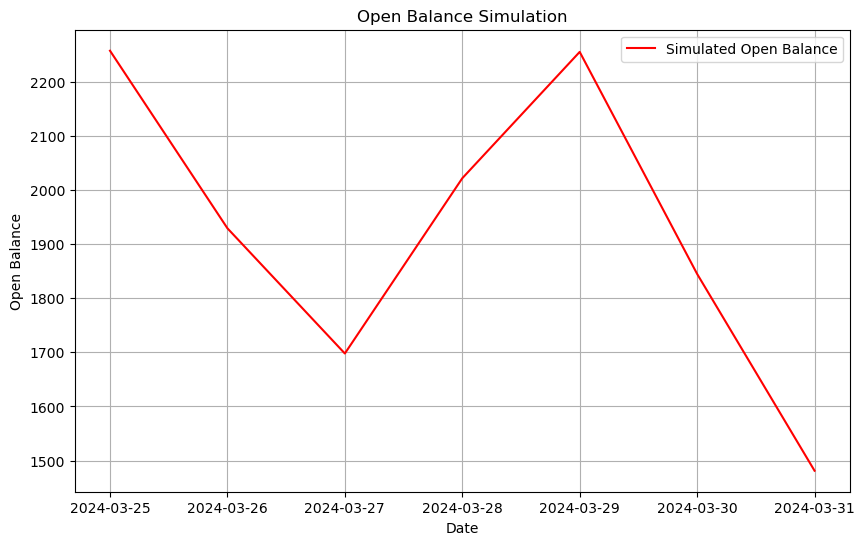

In [18]:
analyse_pred(sim_open, start_date, end_date, var_to_sim='Open Balance')

# Left to do
- Make all numbers whole numbers
- If simulation simulates negative numbers, turn it to 0 instead
- try to make it dynamic so that they can input real numbers for more days than just day 1
- check once more if everything can run smoothly

# Manpower Allocation Optimisation

In [19]:
import itertools

In [20]:
# input updated numbers for today

open_diff = input("The difference in open balance between two subsequent days cannot be more than: ")
range_start = input("On the last day, the final open balance should be in between : ")
range_end = input("Enter Temp Manpower: ")

try:
    open_diff = float(open_diff)
    range_start = float(range_start)
    range_end = float(range_end)
except ValueError:
    print("Error: Please enter valid numbers.")
else:
#     # Initialize the result array
#     cases_closed = []

#     # Perform element-wise multiplication and summation
#     for csa_val, cse_val, temp_val in zip(csa, cse, temp):
#         cases_closed.append(csa_input * csa_val + cse_input * cse_val + temps_input * temp_val)

    print(open_diff,range_start,range_end)

The difference in open balance between two subsequent days cannot be more than: 500
On the last day, the final open balance should be in between : 500
Enter Temp Manpower: 2000
500.0 500.0 2000.0


In [21]:
# Define ranges for case_closure_rate targets
case_closure_rate_range = {
    'CSA': (15, 25),
    'CSE': (10, 35),
    'Temps': (10, 25),
}

# Calculate total case closed based on case closure range and manual input
def calculate_total_case_closed(targets, counts):
    total = 0
    for target, count in zip(targets, counts):
        total += target * count
    #print(total)
    return total

# Define function to check if open_balances differ by at most, the threshold
def within_threshold(open_balances, open_diff):
    for i in range(len(open_balances) - 1):
        if abs(open_balances[i + 1] - open_balances[i]) > open_diff:
            return False
    return True


In [22]:
# Create a list of value ranges for each target
value_ranges = [range(start, end + 1) for start, end in case_closure_rate_range.values()]

# Generate all combinations of values
combinations = list(itertools.product(*value_ranges))

#Print the combinations
for combination in combinations:
    print(combination)

(15, 10, 10)
(15, 10, 11)
(15, 10, 12)
(15, 10, 13)
(15, 10, 14)
(15, 10, 15)
(15, 10, 16)
(15, 10, 17)
(15, 10, 18)
(15, 10, 19)
(15, 10, 20)
(15, 10, 21)
(15, 10, 22)
(15, 10, 23)
(15, 10, 24)
(15, 10, 25)
(15, 11, 10)
(15, 11, 11)
(15, 11, 12)
(15, 11, 13)
(15, 11, 14)
(15, 11, 15)
(15, 11, 16)
(15, 11, 17)
(15, 11, 18)
(15, 11, 19)
(15, 11, 20)
(15, 11, 21)
(15, 11, 22)
(15, 11, 23)
(15, 11, 24)
(15, 11, 25)
(15, 12, 10)
(15, 12, 11)
(15, 12, 12)
(15, 12, 13)
(15, 12, 14)
(15, 12, 15)
(15, 12, 16)
(15, 12, 17)
(15, 12, 18)
(15, 12, 19)
(15, 12, 20)
(15, 12, 21)
(15, 12, 22)
(15, 12, 23)
(15, 12, 24)
(15, 12, 25)
(15, 13, 10)
(15, 13, 11)
(15, 13, 12)
(15, 13, 13)
(15, 13, 14)
(15, 13, 15)
(15, 13, 16)
(15, 13, 17)
(15, 13, 18)
(15, 13, 19)
(15, 13, 20)
(15, 13, 21)
(15, 13, 22)
(15, 13, 23)
(15, 13, 24)
(15, 13, 25)
(15, 14, 10)
(15, 14, 11)
(15, 14, 12)
(15, 14, 13)
(15, 14, 14)
(15, 14, 15)
(15, 14, 16)
(15, 14, 17)
(15, 14, 18)
(15, 14, 19)
(15, 14, 20)
(15, 14, 21)
(15, 14, 22)

In [45]:
def find_best_combinations(combinations, day_0_pred, num_steps, new_cases_pred, open_diff, range_start, range_end, csa_input, cse_input, temps_input):
    valid_combinations = {}

    # check if combination is within threshold
    for combination in combinations:
        manpower_open_sim = [day_0_pred]

        total_case_closed_perday_target = calculate_total_case_closed(combination, [csa_input, cse_input, temps_input])

        for i in range(num_steps - 1):
            manpower_open_sim.append(manpower_open_sim[i] + new_cases_pred[i] - total_case_closed_perday_target)

        if within_threshold(manpower_open_sim, open_diff=open_diff):
            valid_combinations[combination] = manpower_open_sim

    valid_combinations = {key: value for key, value in valid_combinations.items() if range_start <= value[-1] <= range_end}

    # find best combination by using the min combination
    if valid_combinations:
        best_combination = min(valid_combinations, key=lambda x: valid_combinations[x][-1])
        return valid_combinations[best_combination],best_combination
    else:
        return []


In [46]:
opti_combi,manpower_amt=find_best_combinations(combinations, day_0_pred, num_steps, new_cases_pred, open_diff, range_start, range_end, csa_input, cse_input, temps_input)

In [49]:
# opti combi is the list of values to plot

print(opti_combi)

# best number of csa, cse and temps
best_csa_no = manpower_amt[0]
best_cse_no = manpower_amt[1]
best_temps_no = manpower_amt[2]

print(best_csa_no,best_cse_no,best_temps_no)

[2257.6574203150385, 2025.7175651430234, 1749.1190732278124, 1509.5662073823842, 1267.3302704183916, 892.8806051900585, 508.88786914791353]
15 21 25


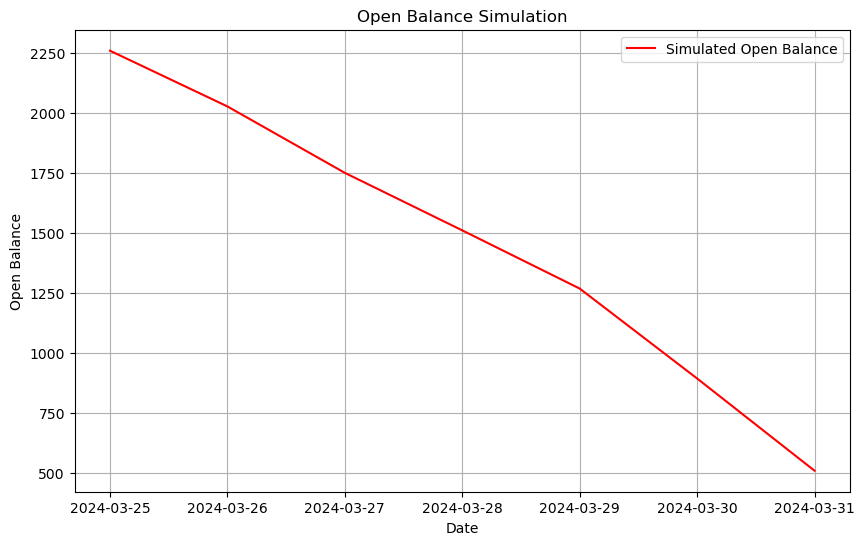

In [44]:
analyse_pred(opti_combi, start_date, end_date, var_to_sim='Open Balance')